In [1]:
import pandas as pd

# Load csv file
df = pd.read_csv("data/yellow_tripdata_2016-03.csv")

# View first few 20 rows
df.head(20)

FileNotFoundError: [Errno 2] No such file or directory: 'data/yellow_tripdata_2016-03.csv'

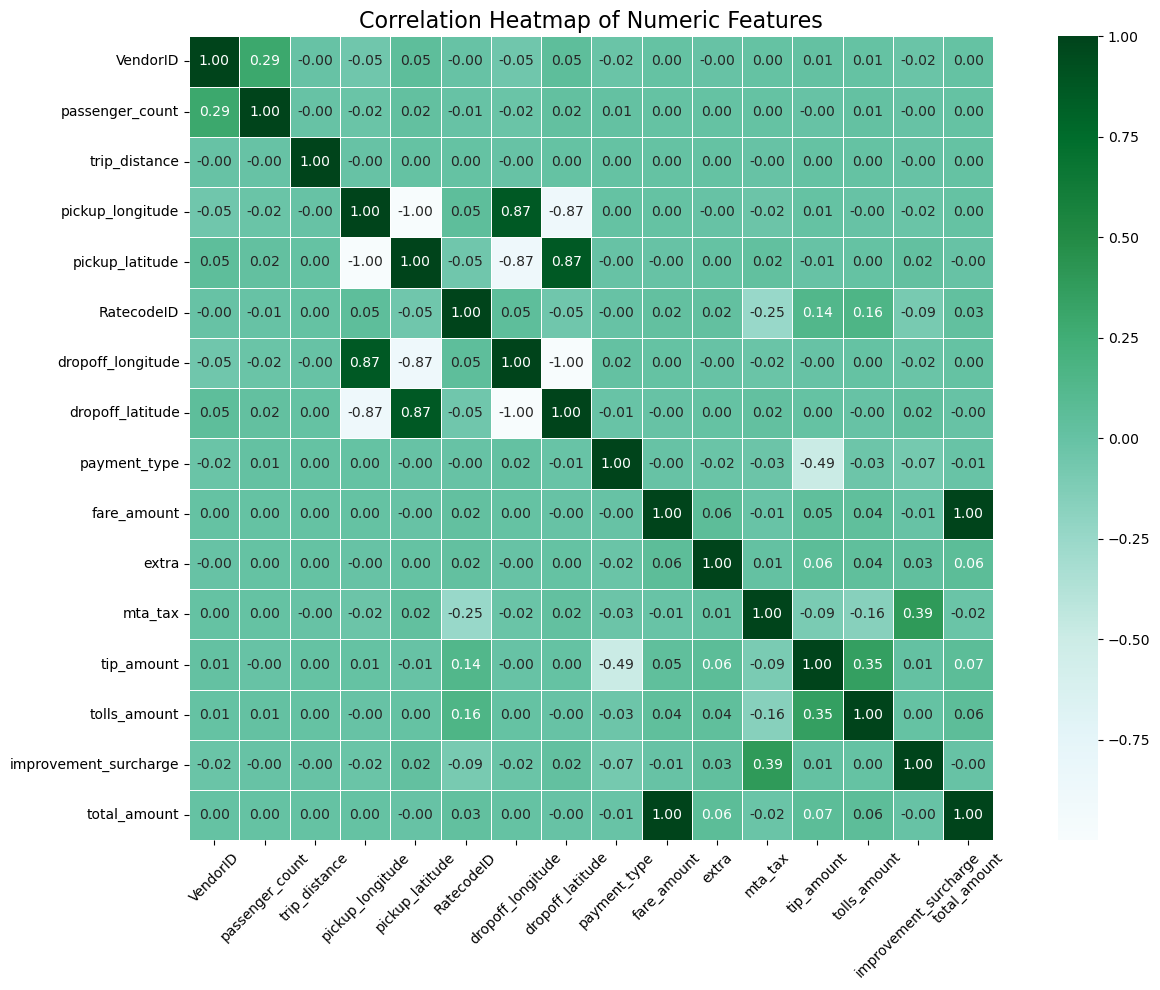

In [3]:
# Create a heatmap to visualize the strength of linear correlations between features.
# Step [EDA]
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert datetime columns to datetime type 
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Set up the heatmap plot with greenish colormap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="BuGn", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
# drop unnecessary columns or columns that might cause data leakage

# Dropoff time [ "tpep_dropoff_datetime"], which is necessary for deriving the speed variable, was excluded because, -> 
# -> in real-world scenarios, the arrival time is unknown beforehand. 
# -> As a result, speed cannot be derived and used as a feature. 
# -> However, this ensures that the model remains realistic and prevents data leakage.

df_cleaned = df.drop(columns=[
    "VendorID", 
    "RatecodeID", 
    "tpep_dropoff_datetime", 
    "fare_amount",                 
    "tip_amount", 
    "tolls_amount",
    "improvement_surcharge",       
    "store_and_fwd_flag",
    "extra",
    "mta_tax",
    "payment_type"
])

In [7]:
df_cleaned.head()

,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount
0,2016-03-01,1,2.50,-73.976746,40.765152,-74.004265,40.746128,12.35
1,2016-03-01,1,2.90,-73.983482,40.767925,-74.005943,40.733166,15.35
2,2016-03-01,2,19.98,-73.782021,40.644810,-73.974541,40.675770,63.80
3,2016-03-01,3,10.78,-73.863419,40.769814,-73.969650,40.757767,41.62
4,2016-03-01,5,30.43,-73.971741,40.792183,-74.177170,40.695053,113.80


In [9]:
# Step [Data Cleaning]

# remove logically inconsistent records
df_cleaned = df_cleaned[(df_cleaned['total_amount'] > 2) & (df_cleaned['passenger_count'] > 0)]
df_cleaned.shape


(12201424, 8)

In [11]:
# Check if we have any missing values
df_cleaned.isna().sum()

tpep_pickup_datetime    0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
total_amount            0
dtype: int64

In [13]:
!pip install geopandas

In [15]:
# creates taxi zones based on lon/lat 
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load taxi zone shapefile
zones = gpd.read_file("taxi_zones/taxi_zones.shp")
zones = zones[["LocationID", "geometry"]].to_crs("EPSG:4326")

# Function to map lat/lon to zone
def map_location_to_zone(df, lon_col, lat_col, zone_df, zone_name):
    coords = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    geo_df = gpd.GeoDataFrame(df[[lon_col, lat_col]].copy(), geometry=coords, crs="EPSG:4326")
    
    joined = gpd.sjoin(geo_df, zone_df, how="left", predicate="within")
    return joined["LocationID"].rename(zone_name)

# Apply mapping functions
df_cleaned["PULocationID"] = map_location_to_zone(df_cleaned, "pickup_longitude", "pickup_latitude", zones, "PULocationID")
df_cleaned["DOLocationID"] = map_location_to_zone(df_cleaned, "dropoff_longitude", "dropoff_latitude", zones, "DOLocationID")


In [17]:
df_cleaned.head()

,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID
0,2016-03-01,1,2.50,-73.976746,40.765152,-74.004265,40.746128,12.35,163.0,68.0
1,2016-03-01,1,2.90,-73.983482,40.767925,-74.005943,40.733166,15.35,142.0,249.0
2,2016-03-01,2,19.98,-73.782021,40.644810,-73.974541,40.675770,63.80,132.0,181.0
3,2016-03-01,3,10.78,-73.863419,40.769814,-73.969650,40.757767,41.62,138.0,162.0
4,2016-03-01,5,30.43,-73.971741,40.792183,-74.177170,40.695053,113.80,238.0,1.0


In [19]:
# add new features
# + day of week
# + is_weekend
# + is_rush_hour
df_cleaned["pickup_hour"] = pd.to_datetime(df_cleaned["tpep_pickup_datetime"]).dt.hour
df_cleaned["pickup_dayofweek"] = pd.to_datetime(df_cleaned["tpep_pickup_datetime"]).dt.dayofweek
df_cleaned["is_weekend"] = df_cleaned["pickup_dayofweek"].isin([5, 6]).astype(int)
df_cleaned["is_rush_hour"] = df_cleaned["pickup_hour"].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

In [21]:
df_cleaned.head()

,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,pickup_hour,pickup_dayofweek,is_weekend,is_rush_hour
0,2016-03-01,1,2.50,-73.976746,40.765152,-74.004265,40.746128,12.35,163.0,68.0,0,1,0,0
1,2016-03-01,1,2.90,-73.983482,40.767925,-74.005943,40.733166,15.35,142.0,249.0,0,1,0,0
2,2016-03-01,2,19.98,-73.782021,40.644810,-73.974541,40.675770,63.80,132.0,181.0,0,1,0,0
3,2016-03-01,3,10.78,-73.863419,40.769814,-73.969650,40.757767,41.62,138.0,162.0,0,1,0,0
4,2016-03-01,5,30.43,-73.971741,40.792183,-74.177170,40.695053,113.80,238.0,1.0,0,1,0,0


In [23]:
!pip install haversine

In [25]:
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Use it with your columns
df_cleaned["haversine_distance"] = haversine_vectorized(
    df_cleaned["pickup_latitude"],
    df_cleaned["pickup_longitude"],
    df_cleaned["dropoff_latitude"],
    df_cleaned["dropoff_longitude"]
)

df_cleaned["haversine_distance"] = df_cleaned["haversine_distance"].round(2)

In [27]:
# Move 'haversine_distance' right next to 'trip_distance'
# PURELY FOR visual purposes to see the difference between trip_distance and haversine_distance
# haversine distance = shortest distance between two points on Earth
cols = df_cleaned.columns.tolist()

# Find the index of trip_distance
idx = cols.index("trip_distance")

# Remove the column and insert it next to trip_distance
cols.remove("haversine_distance")
cols.insert(idx + 1, "haversine_distance")

# Reassign DataFrame with new column order
df_cleaned = df_cleaned[cols]
df_cleaned.head()

,tpep_pickup_datetime,passenger_count,trip_distance,haversine_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,pickup_hour,pickup_dayofweek,is_weekend,is_rush_hour
0,2016-03-01,1,2.50,3.14,-73.976746,40.765152,-74.004265,40.746128,12.35,163.0,68.0,0,1,0,0
1,2016-03-01,1,2.90,4.30,-73.983482,40.767925,-74.005943,40.733166,15.35,142.0,249.0,0,1,0,0
2,2016-03-01,2,19.98,16.60,-73.782021,40.644810,-73.974541,40.675770,63.80,132.0,181.0,0,1,0,0
3,2016-03-01,3,10.78,9.05,-73.863419,40.769814,-73.969650,40.757767,41.62,138.0,162.0,0,1,0,0
4,2016-03-01,5,30.43,20.40,-73.971741,40.792183,-74.177170,40.695053,113.80,238.0,1.0,0,1,0,0


In [29]:
# add is_airport feature 
# there are 3 airports in NYC
AIRPORT_ZONE_IDS = {
    "JFK": 132,
    "LaGuardia": 138,
    "Newark": 1  # This is used for EWR in most TLC datasets
}

airport_ids = list(AIRPORT_ZONE_IDS.values())


In [31]:
df_cleaned["is_airport"] = (
    df_cleaned["PULocationID"].isin(airport_ids) | df_cleaned["DOLocationID"].isin(airport_ids)
).astype(int)

In [33]:
df_cleaned.isna().sum()

# as we can see 
# PULocationID: 189,781 missing values
# DOLocationID: 199,703 missing values

# These columns are dropped since we have approximately 12 million rows, 
# and the missing data represents only a small percentage of the total dataset, 
# making the impact on the overall data negligible.

tpep_pickup_datetime         0
passenger_count              0
trip_distance                0
haversine_distance           0
pickup_longitude             0
pickup_latitude              0
dropoff_longitude            0
dropoff_latitude             0
total_amount                 0
PULocationID            189781
DOLocationID            199703
pickup_hour                  0
pickup_dayofweek             0
is_weekend                   0
is_rush_hour                 0
is_airport                   0
dtype: int64

In [35]:
df_cleaned = df_cleaned.dropna()

In [37]:
# check 
df_cleaned.isna().sum().sum()

0

In [39]:
!pip install requests

In [41]:
# add weather features
# 24hours * 31 days = 720 actual rows to be fetched with weather
import pandas as pd
import requests
from datetime import datetime

# Step 1: NYC coordinates
LAT = 40.7128
LON = -74.0060

# Step 2: Time range
start_date = "2016-03-01"
end_date = "2016-03-31"

# Step 3: Open-Meteo API URL
base_url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": LAT,
    "longitude": LON,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": "temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m",
    "timezone": "auto"
}

# Step 4: Send request
response = requests.get(base_url, params=params)
data = response.json()

# Step 5: Convert to DataFrame
weather_df = pd.DataFrame({
    "datetime": pd.to_datetime(data["hourly"]["time"]),
    "temperature": data["hourly"]["temperature_2m"],
    "humidity": data["hourly"]["relative_humidity_2m"],
    "precipitation": data["hourly"]["precipitation"],
    "wind_speed": data["hourly"]["wind_speed_10m"]
})
weather_df["datetime"] = weather_df["datetime"].dt.floor("h")  # Ensure hourly precision

# Step 6: Floor pickup time to hour
df_cleaned["pickup_hour"] = pd.to_datetime(df_cleaned["tpep_pickup_datetime"]).dt.floor("h")

# Step 7: Merge weather into main DataFrame
df_cleaned = df_cleaned.merge(weather_df, left_on="pickup_hour", right_on="datetime", how="left")

In [43]:
# not needed anymore 
# - tpep_pickup_datetime
# - datetime
df_cleaned = df_cleaned.drop(columns=["tpep_pickup_datetime", "datetime"])

In [51]:
# no longer needed after haversine and zones derivation
df_cleaned = df_cleaned.drop(columns=[
    "pickup_latitude", "pickup_longitude",
    "dropoff_latitude", "dropoff_longitude"
])

In [55]:
# create PU_DO pair
df_cleaned["PU_DO_pair"] = df_cleaned["PULocationID"].astype(str) + "_" + df_cleaned["DOLocationID"].astype(str)

In [59]:
# create distance ratio feature
import numpy as np
df_cleaned["distance_ratio"] = (
    df_cleaned["trip_distance"] / df_cleaned["haversine_distance"].replace(0, np.nan)
).round(2)

In [65]:
# create is_rainy flag based on precipitation
df_cleaned["is_rainy"] = (df_cleaned["precipitation"] > 0.5).astype(int)

In [69]:
def hour_to_bin(hour):
    if 5 <= hour <= 10:
        return "morning"
    elif 11 <= hour <= 15:
        return "midday"
    elif 16 <= hour <= 20:
        return "evening"
    else:
        return "night"

df_cleaned["hour_bin"] = df_cleaned["pickup_hour"].dt.hour.apply(hour_to_bin)

In [73]:
# distance_ration contains NaN values
df_cleaned =  df_cleaned.dropna()

In [75]:
# check
df_cleaned.isna().sum()

passenger_count       0
trip_distance         0
haversine_distance    0
total_amount          0
PULocationID          0
DOLocationID          0
pickup_hour           0
pickup_dayofweek      0
is_weekend            0
is_rush_hour          0
is_airport            0
temperature           0
humidity              0
precipitation         0
wind_speed            0
PU_DO_pair            0
distance_ratio        0
is_rainy              0
hour_bin              0
dtype: int64

In [77]:
df_cleaned["pickup_hour"] = df_cleaned["pickup_hour"].dt.hour

In [79]:
df_cleaned = df_cleaned.drop(columns = ["PULocationID", "DOLocationID"])

In [81]:
df_cleaned.head(20)

,passenger_count,trip_distance,haversine_distance,total_amount,pickup_hour,pickup_dayofweek,is_weekend,is_rush_hour,is_airport,temperature,humidity,precipitation,wind_speed,PU_DO_pair,distance_ratio,is_rainy,hour_bin
0,1,2.50,3.14,12.35,0,1,0,0,0,5.9,58,0.0,18.2,163.0_68.0,0.80,0,night
1,1,2.90,4.30,15.35,0,1,0,0,0,5.9,58,0.0,18.2,142.0_249.0,0.67,0,night
2,2,19.98,16.60,63.80,0,1,0,0,1,5.9,58,0.0,18.2,132.0_181.0,1.20,0,night
3,3,10.78,9.05,41.62,0,1,0,0,1,5.9,58,0.0,18.2,138.0_162.0,1.19,0,night
4,5,30.43,20.40,113.80,0,1,0,0,1,5.9,58,0.0,18.2,238.0_1.0,1.49,0,night
5,5,5.92,6.50,30.36,0,1,0,0,0,5.9,58,0.0,18.2,13.0_161.0,0.91,0,night
6,1,6.20,7.95,21.80,0,1,0,0,1,5.9,58,0.0,18.2,132.0_134.0,0.78,0,night
7,1,0.70,0.84,8.80,0,1,0,0,0,5.9,58,0.0,18.2,140.0_237.0,0.83,0,night
8,3,7.18,7.12,28.00,0,1,0,0,0,5.9,58,0.0,18.2,234.0_74.0,1.01,0,night
9,2,0.54,0.74,5.30,0,1,0,0,0,5.9,58,0.0,18.2,48.0_48.0,0.73,0,night


In [2]:
# save cleaned_df
df_cleaned.to_parquet("df_cleaned.parquet")


NameError: name 'df_cleaned' is not defined

In [85]:
df_cleaned.shape

(11915372, 17)

In [ ]:
df_cleaned = pd.read_parquet("df_cleaned.parquet")

FileNotFoundError: [Errno 2] No such file or directory: 'df_cleaned.parquet'

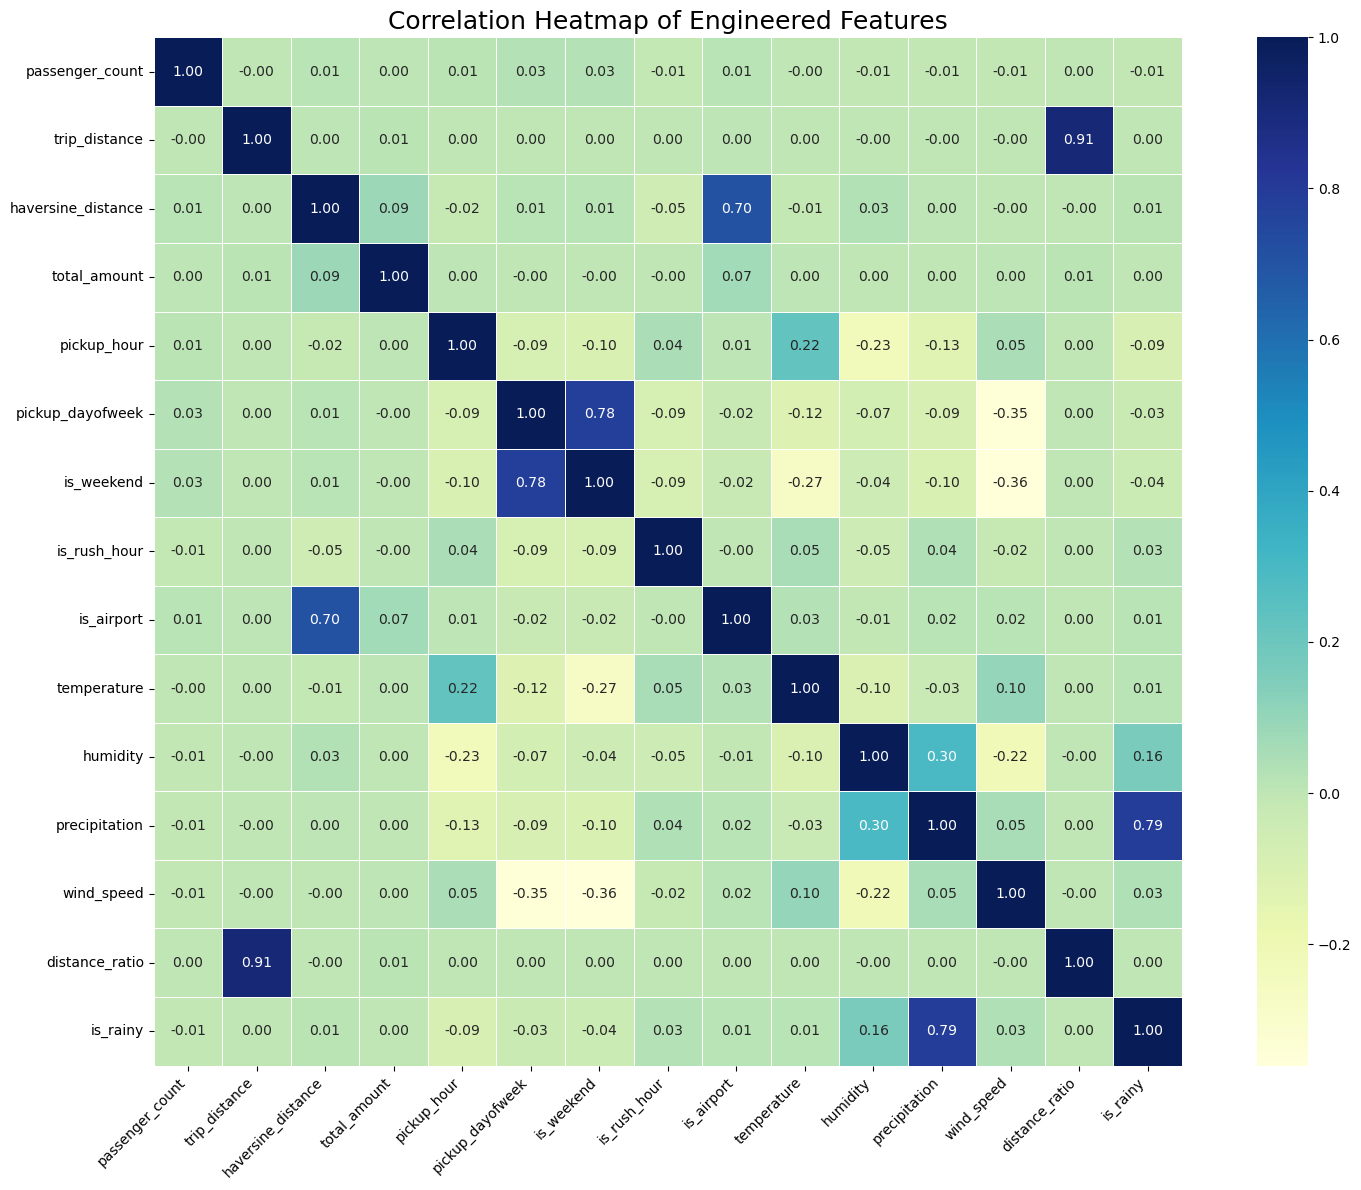

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of your columns (just to be explicit)
cols_to_plot = [
    'passenger_count', 'trip_distance', 'haversine_distance', 'total_amount',
    'pickup_hour', 'pickup_dayofweek', 'is_weekend', 'is_rush_hour', 'is_airport',
    'temperature', 'humidity', 'precipitation', 'wind_speed',
    'distance_ratio', 'is_rainy'
]

# Ensure all selected columns are in the dataframe
heatmap_df = df_cleaned[cols_to_plot].copy()

# Compute correlation matrix
corr_matrix = heatmap_df.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Engineered Features", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [6]:
# 1 million rows, np random state = 42
df_sample = pd.read_parquet("df_sample.parquet")

In [95]:
df_sample.head(10)

,passenger_count,trip_distance,haversine_distance,total_amount,pickup_hour,pickup_dayofweek,is_weekend,is_rush_hour,is_airport,temperature,humidity,precipitation,wind_speed,PU_DO_pair,distance_ratio,is_rainy,hour_bin
11175470,5,2.56,3.01,15.96,22,1,0,0,0,4.7,36,0.0,18.1,114.0_170.0,0.85,0,night
4315789,1,3.15,3.51,17.30,15,0,0,0,0,5.7,81,0.2,21.3,186.0_237.0,0.90,0,midday
9212209,1,1.10,1.75,6.30,6,6,1,0,0,6.4,86,0.0,7.2,100.0_90.0,0.63,0,morning
6769248,1,1.50,2.25,11.15,8,0,0,1,0,0.6,79,0.0,6.6,4.0_114.0,0.67,0,morning
9403186,6,0.89,1.39,10.30,22,3,0,0,0,7.1,94,0.0,13.3,163.0_229.0,0.64,0,night
6823416,2,1.17,1.70,9.30,10,0,0,0,0,3.3,64,0.0,8.6,186.0_137.0,0.69,0,morning
10554481,1,1.68,2.18,10.80,8,0,0,1,0,7.1,97,0.4,12.5,161.0_236.0,0.77,0,morning
1776713,5,1.35,1.84,9.36,2,5,1,0,0,-2.4,65,0.0,12.6,79.0_170.0,0.73,0,night
6461098,1,1.20,1.43,9.12,14,6,1,0,0,4.5,50,0.0,13.2,234.0_249.0,0.84,0,midday
9993887,1,2.10,2.45,14.30,16,5,1,1,0,10.5,57,0.0,8.2,114.0_186.0,0.86,0,evening


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------------------
# Step 1: Define your dataset
# -----------------------------------------
X = df_sample.drop(columns=["total_amount"])
y = df_sample["total_amount"]

# -----------------------------------------
# Step 2: Train-test split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# Step 3: Encode categorical columns (Ordinal)
# -----------------------------------------
categorical_cols = ["PU_DO_pair", "hour_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ],
    remainder="passthrough"
)

# -----------------------------------------
# Step 4: Ridge regression pipeline
# -----------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("ridge", Ridge(random_state=42))
])

# -----------------------------------------
# Step 5: Hyperparameter grid (alpha = regularization strength)
# -----------------------------------------
param_grid = {
    "ridge__alpha": np.logspace(-3, 3, 10)  # [0.001, 0.01, ..., 1000]
}

# -----------------------------------------
# Step 6: GridSearchCV
# -----------------------------------------
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# -----------------------------------------
# Step 7: Fit the model
# -----------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# -----------------------------------------
# Step 8: Evaluate on test set
# -----------------------------------------
y_pred = best_model.predict(X_test)

print("Best alpha:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best alpha: {'ridge__alpha': 1000.0}
MAE: 2.336484721459242
RMSE: 4.277048386395573
R²: 0.8854172359770082


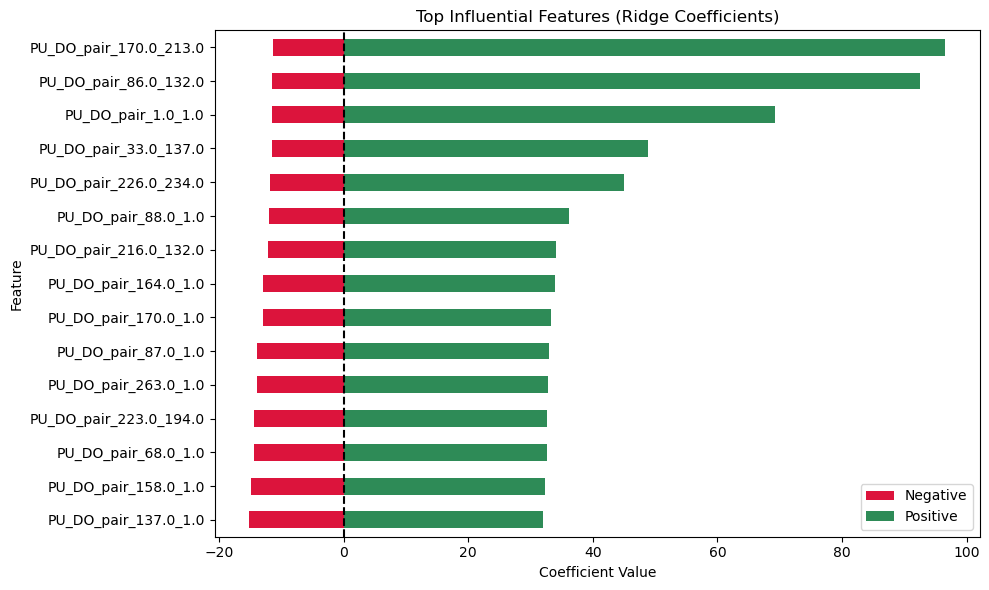

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get feature names after preprocessing
encoded_features = best_model.named_steps['preprocess'].get_feature_names_out()

# Step 2: Get coefficients from the Ridge model
coefficients = best_model.named_steps['ridge'].coef_

# Step 3: Clean feature names (remove 'cat__' and 'remainder__')
clean_names = [name.split('__')[-1] for name in encoded_features]

# Step 4: Create Series and sort
coef_series = pd.Series(coefficients, index=clean_names).sort_values()

# Step 5: Plot top +/- 15 features
plt.figure(figsize=(10, 6))
coef_series.head(15).plot(kind='barh', color='crimson', label='Negative')
coef_series.tail(15).plot(kind='barh', color='seagreen', label='Positive')
plt.title("Top Influential Features (Ridge Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color='black', linestyle='--')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------------------
# Step 2: Define target and features
# -----------------------------------------
X = df_sample.drop(columns=["total_amount"])
y = df_sample["total_amount"]

# -----------------------------------------
# Step 3: Train-test split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# Step 4: Encode categorical columns (Ordinal)
# -----------------------------------------
categorical_cols = ["PU_DO_pair", "hour_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
    ],
    remainder="passthrough"
)

# -----------------------------------------
# Step 5: Random Forest model + pipeline
# -----------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", RandomForestRegressor(n_jobs=-1, random_state=42))
])

# -----------------------------------------
# Step 6: Set up parameter tuning
# -----------------------------------------
param_grid = {
    "rf__n_estimators": [100],
    "rf__max_depth": [10, 15, 20],
    "rf__min_samples_split": [2, 5],
    "rf__max_features": ["sqrt"]
}

search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# -----------------------------------------
# Step 7: Train the model
# -----------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# -----------------------------------------
# Step 8: Evaluate performance
# -----------------------------------------
y_pred = best_model.predict(X_test)

print("Best Params:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
MAE: 1.9339617291844997
RMSE: 3.6693245835503654
R²: 0.9156658972962635


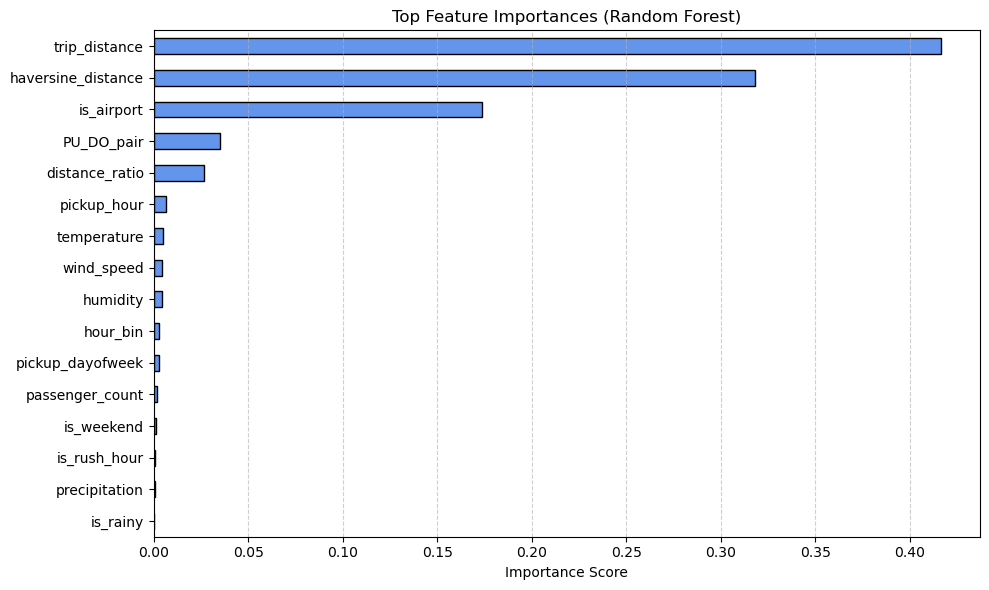

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract encoded feature names and importances
encoded_features = best_model.named_steps['preprocess'].get_feature_names_out()
importances = best_model.named_steps['rf'].feature_importances_

# Step 2: Clean feature names (remove transformer prefixes)
clean_names = [name.split('__')[-1] for name in encoded_features]

# Step 3: Create and sort importance series
feat_imp = pd.Series(importances, index=clean_names).sort_values(ascending=False)

# Step 4: Plot top 20
plt.figure(figsize=(10,6))
feat_imp[:20].plot(kind='barh', color='cornflowerblue', edgecolor='black')
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# -----------------------------------------
# Step 1: Define target and features
# -----------------------------------------
X = df_sample.drop(columns=["total_amount"])
y = df_sample["total_amount"]

# -----------------------------------------
# Step 2: Train-test split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# Step 3: Categorical encoding (Ordinal)
# -----------------------------------------
categorical_cols = ["PU_DO_pair", "hour_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
    ],
    remainder="passthrough"
)

# -----------------------------------------
# Step 4: XGBoost model + pipeline
# -----------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist",        # Use "gpu_hist" if using GPU
        n_jobs=-1
    ))
])

# -----------------------------------------
# Step 5: Parameter grid for tuning
# -----------------------------------------
param_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [5, 7, 10],
    "xgb__learning_rate": [0.01, 0.1],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

# -----------------------------------------
# Step 6: GridSearchCV
# -----------------------------------------
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# -----------------------------------------
# Step 7: Fit model
# -----------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# -----------------------------------------
# Step 8: Evaluate performance
# -----------------------------------------
y_pred = best_model.predict(X_test)

print("Best Params:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}
MAE: 1.8593285549815477
RMSE: 3.6130124733057376
R²: 0.9182345390973417


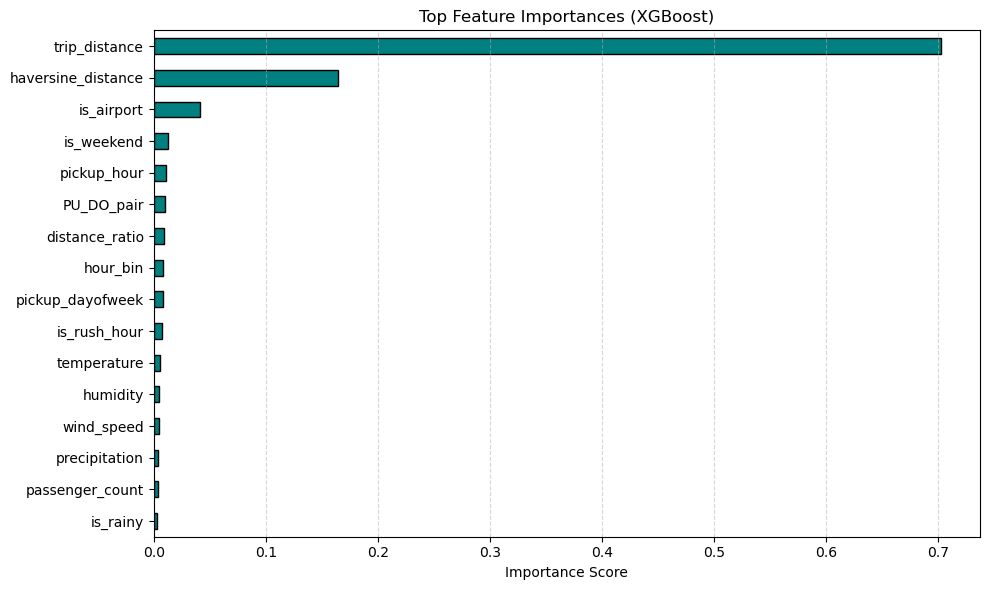

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Get feature names after preprocessing
xgb_feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

# Step 2: Get feature importances from the trained XGBoost model
importances = best_model.named_steps["xgb"].feature_importances_

# Step 3: Clean feature names (remove transformer prefixes)
clean_names = [name.split("__")[-1] for name in xgb_feature_names]

# Step 4: Create importance series
feat_imp = pd.Series(importances, index=clean_names).sort_values(ascending=False)

# Step 5: Plot top 20
plt.figure(figsize=(10, 6))
feat_imp[:20].plot(kind="barh", color='teal', edgecolor='black')
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------------------
# Step 1: Dataset
# -----------------------------------------
X = df_sample.drop(columns=["total_amount"])
y = df_sample["total_amount"]

# -----------------------------------------
# Step 2: Train-test split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# Step 3: Encode categorical features (Ordinal)
categorical_cols = ["PU_DO_pair", "hour_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
    ],
    remainder="passthrough"
)

# -----------------------------------------
# Step 4: Define pipeline with HistGradientBoosting
# -----------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("hgb", HistGradientBoostingRegressor(
        random_state=42,
        verbose=0
    ))
])

# -----------------------------------------
# Step 5: Hyperparameter grid
# -----------------------------------------
param_grid = {
    "hgb__max_iter": [100, 200],
    "hgb__max_depth": [5, 10],
    "hgb__learning_rate": [0.01, 0.1],
    "hgb__l2_regularization": [0.0, 1.0]
}

# -----------------------------------------
# Step 6: GridSearchCV
# -----------------------------------------
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# -----------------------------------------
# Step 7: Fit the model
# -----------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# -----------------------------------------
# Step 8: Evaluate performance
# -----------------------------------------
y_pred = best_model.predict(X_test)

print("Best Params:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\assyl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\assyl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Best Params: {'hgb__l2_regularization': 1.0, 'hgb__learning_rate': 0.1, 'hgb__max_depth': 10, 'hgb__max_iter': 200}
MAE: 1.9156819838390302
RMSE: 3.6456114998803493
R²: 0.9167523968111276


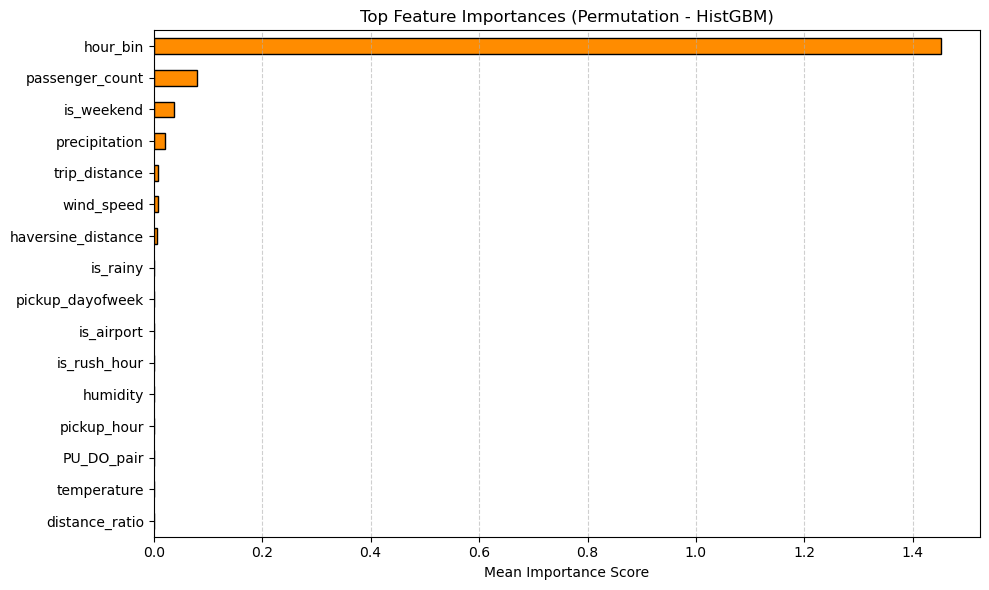

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# -----------------------------------------
# Step 1: Compute permutation importance
# -----------------------------------------
result = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# -----------------------------------------
# Step 2: Get feature names from preprocessor
# -----------------------------------------
encoded_features = best_model.named_steps["preprocess"].get_feature_names_out()
clean_names = [name.split("__")[-1] for name in encoded_features]

# -----------------------------------------
# Step 3: Create a Series of importances
# -----------------------------------------
perm_importance = pd.Series(result.importances_mean, index=clean_names).sort_values(ascending=False)

# -----------------------------------------
# Step 4: Plot top 20 important features
# -----------------------------------------
plt.figure(figsize=(10, 6))
perm_importance[:20].plot(kind='barh', color='darkorange', edgecolor='black')
plt.title("Top Feature Importances (Permutation - HistGBM)")
plt.xlabel("Mean Importance Score")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
